In [4]:
import math
import numpy as np

# Method interfaces

In [5]:
class IterativeMethod:
    def compute(self, A: [[float]], b: [float], tolerance: float, max_iteration_count: int) -> ([float], int, bool):
        raise AssertionError("Not implemented yet")

In [6]:
class ForwardMethod:
    def compute(self, A: [[float]], b: [float]) -> [float]:
        raise AssertionError("Not implemented yet")

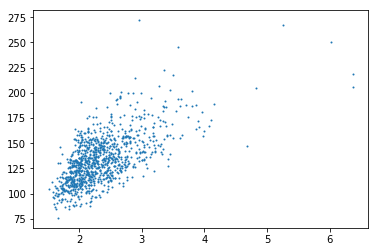

In [36]:
import time
import matplotlib.pyplot as plt

class IterativeMethodResult:
    def __init__(self, method: IterativeMethod, cond: float, x: [float], iterations: int , ok: bool, ex_time: int):
        self.cond = math.log10(cond)
        self.method = method
        self.x = x
        self.iterations = iterations
        self.ok = ok
        self.ex_time = ex_time 
    def __str__(self):
        return "cond:{}; time:{}; iterations:{}".format(self.cond, self.ex_time, self.iterations)
    

class MethodsTest:
    @staticmethod
    def _rand_matrix(size: int) -> [[float]]:
        A = np.array(np.random.rand(size, size), dtype=np.float64)
        A = np.tril(A) + np.tril(A, -1).T
        return A.T * A
    
    @staticmethod
    def _triangle_matrix(size: int) -> [[float]]:
        A = np.array(np.random.rand(size, size), dtype=np.float64)
        return np.tril(A).T
    
    @staticmethod
    def _diag_matrix(size: int) -> [[float]]:
        A = np.array(np.random.rand(size, size), dtype=np.float64)
        return np.tril(A).T
    
    @staticmethod
    def _hilbert_matrix(size: int) -> [[float]]:
        ans = np.zeros((size, size), dtype=np.float64)
        for i in range(size):
            for j in range(size):
                ans[i, j] = 1.0 / (i + j + 1)
        return ans
    
    @staticmethod
    def _n_rand_matrix(n: int, size: int) -> [[[float]]]:
        a = []
        for i in range(n):
            a.append(MethodsTest._rand_matrix(size))
        a.sort(key=lambda x: np.linalg.cond(x))
        return a
    
    @staticmethod
    def _n_rand_b(n: int, size: int) -> [[float]]:
        b = []
        for i in range(n):
            b.append(np.random.rand(size))
        return b
    
    @staticmethod
    def test_iterative_method(method: IterativeMethod, size: int) -> [IterativeMethodResult]: 
        max_iteration_count = 100_000
        tolerance = 1e-7
        matrix_count = 1000
        results = []
        matrix_array = MethodsTest._n_rand_matrix(matrix_count, size)
        b_array = MethodsTest._n_rand_b(matrix_count, size)
        for i in range(len(matrix_array)):
            start = time.time()
            x, iterations, ok = method.compute(matrix_array[i], b_array[i], tolerance, max_iteration_count)
            end = time.time() - start
            results.append(IterativeMethodResult(method, np.linalg.cond(matrix_array[i]), x, iterations, ok, end))
        return results
    
    @staticmethod
    def draw_iterative_method_time(results: [IterativeMethodResult]):
        results = list(filter(lambda x: x.ok, results))
        times = list(map(lambda x: x.iterations,results))
        cond = list(map(lambda x: x.cond, results))
        plt.scatter(cond, times, s = 1)

# method_data = MethodsTest.test_iterative_method(GradientMethod(), 25)
# print('\n'.join(list(map(str, temp))))
# MethodsTest.draw_iterative_method_time(temp)


# Methods

In [32]:
class GaussMethod(ForwardMethod):
    @staticmethod
    def _find_max_row(A: [[float]], ind: int) -> int:
        cur_max = A[ind, ind]
        cur_ind = ind
        for i in range(ind, len(A)):
            cur_val = A[i, ind]
            if cur_max < cur_val:
                cur_max = cur_val
                cur_ind = i
        return cur_ind
    
    @staticmethod
    def normalize_line(A: [[float]], ind: int):
        a = A[ind, ind]
        for j in range(ind, len(A)):
            A[ind, j] = A[ind, j] / a
            
    @staticmethod
    def go_down(A: [[float]], b: [float], ind: int):
        for i in range(ind + 1, len(A)):
            main_val = A[i, ind]
            b[i] -= main_val * b[ind]
            for j in range(ind, len(A)):
                A[i, j] -= main_val * A[ind, j]
            
    
    def compute(self, A: [[float]], b: [float]) -> [float]:
        # make matrix diagonal
        for i in range(len(A)):
            # find row with max value in 'i' column -- main row
            j = GaussMethod._find_max_row(A, i)
            # swap main row and current
            A[[i, j]] = A[[j, i]]
            
            b[i] /= A[i, i]
            GaussMethod.normalize_line(A, i)
            GaussMethod.go_down(A, b, i)
        # get solution
        ans = np.zeros(len(A))
        for i in reversed(range(len(A))):
            ans[i] = b[i]
            for j in reversed(range(i + 1, len(A))):
                ans[i] -= A[i][j] * ans[j]
        return ans

[1.1020202  0.99090909 1.01111111]


In [20]:
class GradientMethod(IterativeMethod):
    def compute (self, A, b, tol = 1e-7, max_iter = 100000):
        iters = 0
        (n, m) = np.shape(A)
        x = np.random.rand(m)
        r = b - np.dot(A, x)
        z = r
        while iters < max_iter and np.linalg.norm(np.dot(A, x) - b) > tol:
            prodAz = np.dot(A, z)
            rNormSquared = np.linalg.norm(r) ** 2 # just for performance
            
            a = rNormSquared / np.dot(prodAz, z)
            x += a * z
            r -= a * prodAz
            beta = np.linalg.norm(r) ** 2 / rNormSquared
            z = r + beta * z
            iters += 1
        return tuple([x, iters, iters != max_iter])

In [2]:
# same lenght
def deltaVectorsNorm(x, y):
    res = 0.0
    for i in range (0, len(x)):
        res += (y[i] - x[i]) ** 2
    return math.sqrt(res)

In [3]:
# Ax = b
# epsiolon - accuracy parameter
# method -
#   0 - Jacobi
#   1 - Seidel (determinant(B) should be less 1)
#   2 - Seidel with relaxation
# wRelax - relaxation parameter
def templateJakobiAndSeidel(A, b, epsilon, method, wRelax):
    iterations = 0
    maxIterations = 100
    B = []
    d = []
    xn = []
    x = []
    
    for i in range (0, len(A)):
        d.append(b[i] / A[i][i])
        xn.append(d[i])
        x.append(d[i] + 1000)
        B.append([])
        for j in range (0, len(A[i])):
            B[i].append(-A[i][j] / A[i][i])
        B[i][i] = 0.0
    
    # detB = determinant(B)
    # eps = (1 - detB) * epsilon / detB
    eps = epsilon
    
    while ((deltaVectorsNorm(x, xn) > eps) and iterations < maxIterations):
        x = xn.copy()
        for i in range (0, len(B)):
            xn[i] = 0.0
            for j in range (0, len(B[i])):
                xn[i] += B[i][j] * (xn[j] if (j < i and method > 0) else x[j])
            xn[i] += d[i]
            if (method == 2):
                xn[i] = wRelax * xn[i] + (1 - wRelax) * x[i]
        iterations = iterations + 1
            
    
    return (xn, iterations)

In [4]:
def jakobi(A, b, epsilon):
    return templateJakobiAndSeidel(A, b, epsilon, 0, 0) 

In [5]:
def seidel(A, b, epsilon):
    return templateJakobiAndSeidel(A, b, epsilon, 1, 0) 

In [6]:
def seidelRelax(A, b, epsilon, wRelax):
    return templateJakobiAndSeidel(A, b, epsilon, 2, wRelax) 

In [7]:
def test_jakobi():
    A = [[10,1,-1],[1,10,-1],[-1,1,10]]
    b = [11,10,10]
    print ("Jakobi")
    (ans, it) = jakobi(A, b, 0.000001)
    print (ans)
    print (it)

test_jakobi()

Jakobi
[1.1020202000000001, 0.9909091, 1.0111111]
6


In [8]:
def test_seidel():
    A = [[10,1,-1],[1,10,-1],[-1,1,10]]
    b = [11,10,10]
    print ("Seidel")
    (ans, it) = seidel(A, b, 0.000001)
    print (ans)
    print (it)

test_seidel()

Seidel
[1.1020201985951001, 0.99090909050459, 1.011111110809051]
5


In [9]:
def test_seidel_relax():
    A = [[10,1,-1],[1,10,-1],[-1,1,10]]
    b = [11,10,10]
    print ("Seidel with relaxation")
    (ans, it) = seidelRelax(A, b, 0.000001, 0.08)
    print (ans)
    print (it)

test_seidel_relax()

Seidel with relaxation
[1.1020120682451873, 0.9909105605032578, 1.0111016830698611]
94
